In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as ss
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
from par2vec.common import *

### Load Reuters

In [2]:
# Load tokenized reuters
topic2id = np.load('data/reuters/reuters_topic2id.npy').item(0)
id2topic = np.load('data/reuters/reuters_id2topic.npy').item(0)
topics = list(np.load('data/reuters/reuters_topics.npy'))

word2id = np.load('data/reuters/reuters_word2id.npy').item(0)
id2word = np.load('data/reuters/reuters_id2word.npy').item(0)
tokenized = list(np.load('data/reuters/reuters_tokenized.npy'))

In [234]:
# Load tokenized 20_newsgroup
topic2id = np.load('data/20_newsgroup/20newsgroup_topic2id.npy').item(0)
id2topic = np.load('data/20_newsgroup/20newsgroup_id2topic.npy').item(0)
topics = list(np.load('data/20_newsgroup/20newsgroup_topics.npy'))

word2id = np.load('data/20_newsgroup/20newsgroup_word2id.npy').item(0)
id2word = np.load('data/20_newsgroup/20newsgroup_id2word.npy').item(0)
tokenized = list(np.load('data/20_newsgroup/20newsgroup_tokenized.npy'))

In [3]:
print('Unique words: ', len(word2id))
print('Unique docs:  ', len(tokenized))

Unique words:  59575
Unique docs:   20578


### Compute document graphs and essentials

In [21]:
# Create graphs for N documents
max_w=13

counts = np.zeros((len(tokenized), max_w))
entropies = []
cooccurences = []
weights = []
for i, (_, A_o, A_i) in enumerate(get_adj(tokenized, word2id)):
    if i % 5000 == 0:
        print('{}/{}'.format(i, len(tokenized)))
        
    # Graph
    A_i.sum_duplicates()
    A = A_i.data
    
    # Weight counts
    weights.append(A)
    bincount = np.bincount(A.astype(int))
    for j in range(min(len(bincount), max_w)):
        counts[i, j] = bincount[j]
        
    # Entropies
    entropies.append(sp.stats.entropy((A_o + A_i).data))
    
    # cooccurences
    cooccurences.append(sum(A>0))
    

# Parse data
x = np.arange(1, max_w)
y_mean = np.mean(counts[:,1:], axis=0)
y_std = np.std(counts[:,1:], axis=0)

0/20578
5000/20578
10000/20578
15000/20578
20000/20578


### Stats

In [22]:
flat_weights = [x for sublist in weights for x in sublist]
print('Weights MEAN:', np.mean(flat_weights))
print('Weights STD: ', np.std(flat_weights))

Weights MEAN: 1.10402303406
Weights STD:  0.495527810209


In [23]:
print('Coocurrences MEAN: ', np.mean(cooccurences))
print('Coocurrences STD:  ', np.std(cooccurences))

Coocurrences MEAN:  115.258625717
Coocurrences STD:   118.801421714


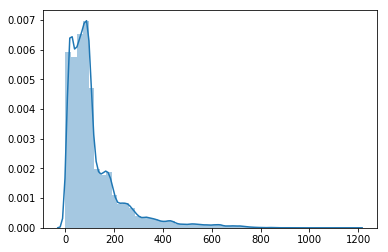

In [24]:
sns.distplot(cooccurences)
plt.show()

### Plot distribution of non-zero graph weights

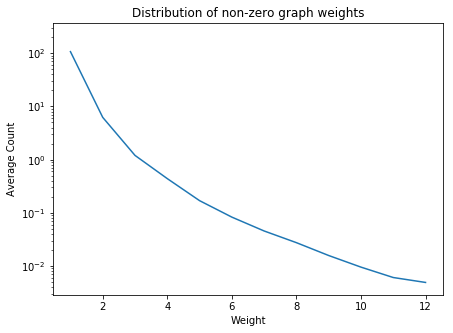

In [25]:
plt.figure(figsize=(7,5))
plt.title('Distribution of non-zero graph weights')
plt.xlabel('Weight')
plt.ylabel('Average Count')
plt.yscale('log')
plt.errorbar(x, y_mean, yerr=y_std)
plt.savefig('plots/dist_nonzero_graph_weights.png')
plt.show()

### Plot distribution graph entropies 

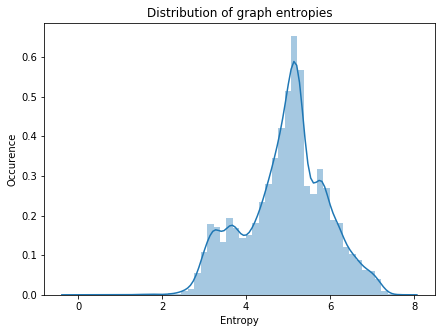

In [26]:
plt.figure(figsize=(7,5))
plt.title('Distribution of graph entropies')
plt.xlabel('Entropy')
plt.ylabel('Occurence')
sns.distplot(entropies, bins=50)
plt.savefig('plots/dist_graph_entropies.png')
plt.show()

### Plot distribution of topics

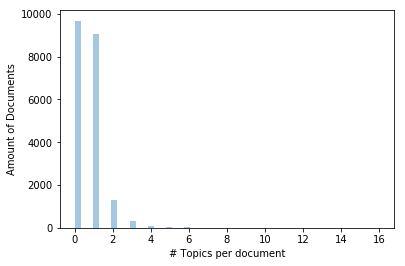

In [27]:
topic_count = [len(x) for x in topics]
plt.xlabel('# Topics per document')
plt.ylabel('Amount of Documents')
sns.distplot(topic_count, kde=False, )
plt.savefig('plots/dist_topics_over_docs.png')
plt.show()

### Plot class imbalance

Counts per class: [2390   61    4   54    1  116    3   72    2    1    1   75    5    6  142
   77    3  247    1    2   62    3    1  111    4  597    1    3    1  215
   15 3729    3    2   27   64  163  133  613   10    2   25    1   27   19
   18    7  493    7   65   65    7   75    8   35   17    1    2    2    3
  111   16   49  767  186    7  128   11    3    4   14  187   29    3   42
    2    1   40   12    4    4    6    6    3    1    8   34    1   82   27
   66    1   48    1    2    3    3  285   37    1   35   25   25  115   21
   32  183    2    8   15    4   15   32  538  132  298    2   32   68   44]


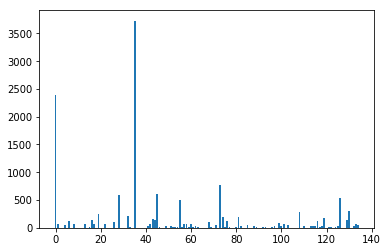

In [29]:
flat_topics = [item for sublist in topics for item in sublist]
topic_i, topic_count = np.unique(flat_topics, return_counts=True)
print('Counts per class:', topic_count)
plt.bar(topic_i, topic_count)
plt.savefig('plots/dist_topic_counts.png')
plt.show()

### Report Plots

In [31]:
def gen_doc_topic(dim_t=30, dim_d=16):
    num_t = np.random.randint(1,np.minimum(dim_t, 3))
    ts = np.random.choice(dim_t, num_t, replace=False)
    ts_boost = np.random.rand(np.shape(ts)[0])*3. + 0.5
    ts_boost = ts_boost[np.newaxis,:, np.newaxis]
    d = np.random.rand(1,dim_t, dim_d)
    d[...,ts, :]*= ts_boost
    return d
    
num_docs, dim_t, dim_d = 100, 30, 16
docs = np.zeros((num_docs, dim_t, dim_d))
for d in range(num_docs):
    docs[d,:,:] = gen_doc_topic(dim_t, dim_d)

In [32]:
topic_doc = np.zeros((len(topics), 135))
for i, topic in enumerate(topics):
    topic_doc[i][topic] = 1

In [33]:
# for i, k in enumerate(np.sum(topic_doc, axis=0).astype(int)):
#      print(i, k)
topic_doc[:, 81]>0
#81 en 74

array([False, False, False, ..., False, False, False], dtype=bool)

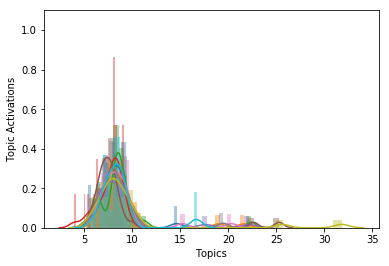

In [34]:
for d in docs[:10]:
    sns.distplot(np.sum(d,1), bins=dim_t, hist=True, norm_hist=True)
    
plt.xlabel('Topics')
plt.ylabel('Topic Activations')
plt.ylim([0.,1.1])
plt.show()

Counts per class: [2390   61    4   54    1  116    3   72    2    1    1   75    5    6  142
   77    3  247    1    2   62    3    1  111    4  597    1    3    1  215
   15 3729    3    2   27   64  163  133  613   10    2   25    1   27   19
   18    7  493    7   65   65    7   75    8   35   17    1    2    2    3
  111   16   49  767  186    7  128   11    3    4   14  187   29    3   42
    2    1   40   12    4    4    6    6    3    1    8   34    1   82   27
   66    1   48    1    2    3    3  285   37    1   35   25   25  115   21
   32  183    2    8   15    4   15   32  538  132  298    2   32   68   44]


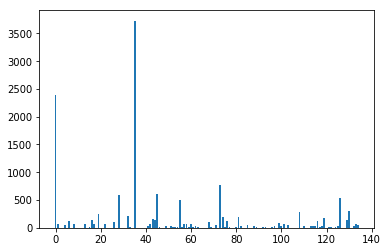

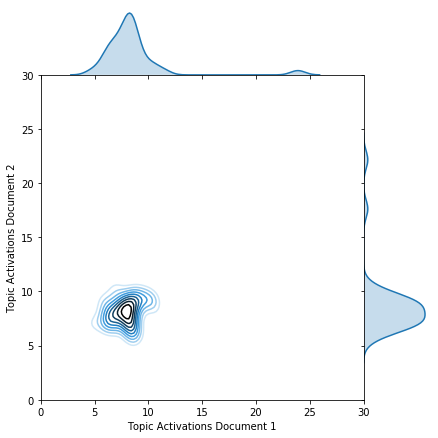

In [35]:
topic_i, topic_count = np.unique(flat_topics, return_counts=True)
print('Counts per class:', topic_count)
plt.bar(topic_i, topic_count)
plt.savefig('plots/dist_topic_counts.png')
fig = sns.jointplot(x=np.sum(docs[np.random.randint(dim_d)], 1), 
                    y=np.sum(docs[np.random.randint(dim_d)],1), 
                    kind="kde", space=0, stat_func=None, xlim=(0,30),ylim=(0,30), shade=False);
fig.set_axis_labels('Topic Activations Document 1', 'Topic Activations Document 2')
plt.show()

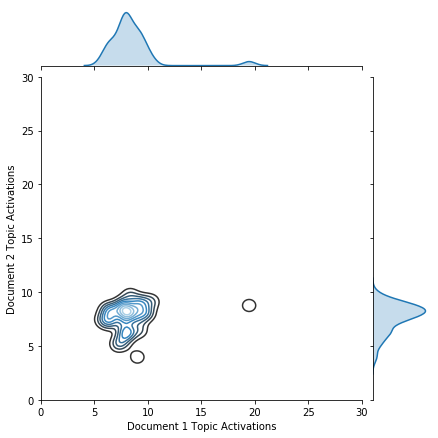

In [37]:
d1 = np.sum(docs[np.random.randint(dim_d)], 1)
d2 = np.sum(docs[np.random.randint(dim_d)], 1)
g = sns.JointGrid(x=d1, y=d2, xlim=(0, 30), ylim=(0, 30))
g = g.plot_joint(sns.kdeplot, cmap="Blues_d")
g = g.plot_marginals(sns.kdeplot, shade=True)
g.set_axis_labels('Document 1 Topic Activations', 'Document 2 Topic Activations')